In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-test-1lakh/Test_data_1L.csv
/kaggle/input/quora-train-1lakh/Train_data_1L.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!pip install fuzzywuzzy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import nltk
import time
from matplotlib.pyplot import figure
#from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import optuna
from optuna import Trial, visualization

import gensim

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df=pd.read_csv('/kaggle/input/quora-train-1lakh/Train_data_1L.csv')
df.head()

test_data=pd.read_csv('/kaggle/input/quora-test-1lakh/Test_data_1L.csv')
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [4]:
df['is_duplicate'].value_counts(normalize=True)

0    0.62746
1    0.37254
Name: is_duplicate, dtype: float64

In [5]:
df=df.dropna()
df.shape

(100000, 6)

<AxesSubplot:>

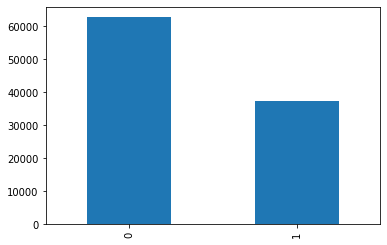

In [6]:
df_is_dup=df['is_duplicate'].value_counts()
df_is_dup.plot.bar()

In [7]:
print(df.question1.apply(len).min())
print(df.loc[df.question1.apply(len).argmin()])
print(df.question2.apply(len).min())
print(df.loc[df.question2.apply(len).argmin()])


1
id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object
1
id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object


In [8]:
def preprocess_text(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'").replace("won't", "will not")\
                           .replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"http\S+", "", x)
    x = re.sub('\W', ' ', x)
    
    lemmatizer = WordNetLemmatizer()
    x = lemmatizer.lemmatize(x)
    bfs = BeautifulSoup(x)
    x = bfs.get_text()
    x = x.strip()
    return x

In [9]:
def data_cleaning(data):
    newdata = pd.DataFrame()
    newdata['question1_final'] = data['question1'].apply(preprocess_text)
    newdata['question2_final'] = data['question2'].apply(preprocess_text)
    return newdata

In [10]:
nltk.download('omw-1.4')
train_data=data_cleaning(df)

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [11]:
test_data=data_cleaning(test_data)
test_data.head()

,question1_final,question2_final
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require
2,what but is the best way to send money from ch...,what you send money to china
3,which food not emulsifiers,what foods fibre
4,how aberystwyth start reading,how their can i start reading


In [12]:
def doesMatch (q, match):
    q1, q2 = q['question1_final'], q['question2_final']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [13]:
def feature_extract(data):
    data['q1_char_num'] = data.question1_final.apply(len)
    data['q2_char_num'] = data.question2_final.apply(len)
    data['q1_word_num'] = data.question1_final.apply(lambda x: len(x.split()))
    data['q2_word_num'] = data.question2_final.apply(lambda x: len(x.split()))
    
    data['total_word_num'] = data['q1_word_num'] + data['q2_word_num']
    data['differ_word_num'] = abs(data['q1_word_num'] - data['q2_word_num'])
    data['same_first_word'] = data.apply(lambda x: doesMatch(x, 0) ,axis=1)
    data['same_last_word'] = data.apply(lambda x: doesMatch(x, -1) ,axis=1)
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split()))) ,axis=1)
    data['total_unique_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['total_unique_word_num_ratio'] = data['total_unique_word_num'] / data['total_word_num']
    
    data['common_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split()))) ,axis=1)
    data['common_word_ratio'] = data['common_word_num'] / data['total_unique_word_num']
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    
    data['common_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['common_word_withoutstopword_ratio'] = data['common_word_withoutstopword_num'] / data['total_unique_word_withoutstopword_num']
    data['common_word_withoutstopword_ratio_min'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: min(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    data['common_word_withoutstopword_ratio_max'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: max(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x.question1_final, x.question2_final), axis=1)
    data.fillna(0, inplace=True)
    return data

In [14]:
train_data = feature_extract(train_data)
test_data = feature_extract(test_data)

In [16]:
train_data.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,1.000000,0.916667,5,0.833333,1.0,0.833333,93,100,100,93
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,50,87,10,15,25,5,1,0,...,0.700000,0.500000,4,0.363636,0.8,0.400000,66,74,86,63
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,10,24,4,1,0,...,0.400000,0.285714,2,0.222222,0.4,0.333333,54,53,66,66
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,49,64,11,13,24,2,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,35,39,36,36
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,75,38,13,7,20,6,1,0,...,0.571429,0.307692,2,0.153846,0.4,0.200000,46,55,67,47


In [17]:
test_data.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,56,67,11,14,25,3,0,0,...,0.300000,0.230769,3,0.272727,0.6,0.333333,46,45,58,55
1,should i have a hair transplant at age 24 how...,how much cost does hair transplant require,65,42,14,7,21,7,0,0,...,0.714286,0.357143,4,0.500000,0.8,0.571429,49,57,82,58
2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,20,8,1,0,...,0.833333,0.416667,3,0.500000,1.0,0.500000,60,82,92,55
3,which food not emulsifiers,what foods fibre,26,16,4,3,7,1,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,52,56,52,52
4,how aberystwyth start reading,how their can i start reading,31,29,4,6,10,2,1,1,...,0.750000,0.500000,2,0.666667,1.0,0.666667,70,66,74,66


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [54]:
tfidf=TfidfVectorizer(min_df=5,stop_words='english',max_features=100)
df_tfidf_train1=tfidf.fit_transform(train_data['question1_final']).toarray()
df_tfidf_test1=tfidf.transform(test_data['question1_final']).toarray()



In [55]:
df_tfidf_train2=tfidf.fit_transform(train_data['question2_final']).toarray()
df_tfidf_test2=tfidf.transform(test_data['question2_final']).toarray()

In [56]:
df_tfidf_train1=pd.DataFrame(df_tfidf_train1)
df_tfidf_train2=pd.DataFrame(df_tfidf_train2)
df_tfidf_test1=pd.DataFrame(df_tfidf_test1)
df_tfidf_test2=pd.DataFrame(df_tfidf_test2)